<a href="https://colab.research.google.com/github/tg-bomze/NeuralStockPredictor/blob/master/NeuralStockPredictor_Eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><font color="red" size="+3">NeuralStockPredictor

---

<b><font color="red">P.S. Sorry for my bad English. I translate using Google Translator</font></b>

##**The research was conducted by:**
GitHub: [@tg-bomze](https://github.com/tg-bomze)

Telegram: [@bomze](https://t.me/bomze) 

Twitter: [@tg_bomze](https://twitter.com/tg_bomze)

# <b><font color="red" size="+2">Research:

Stock Price Prediction using Convolutional and Recurrent Neural Networks on Keras

In [ ]:
#@title <b><font color="gree" size="+2">Install the all needed libraries {display-mode: "form"}
%%time
!pip install imgaug==0.2.5
!pip install scipy==1.2
!pip install talos
!pip install --upgrade yfinance

from IPython.display import clear_output

import plotly 
import plotly.graph_objects as go

import matplotlib
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import talos as ta
import math
import time
import sys
import os

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from talos.utils.gpu_utils import parallel_gpu_jobs
from talos.model.normalizers import lr_normalizer
from matplotlib.dates import bytespdate2num
from google.colab import files
from matplotlib import style
from time import time

from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute, Reshape
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers import Embedding, Input, SpatialDropout1D, AtrousConvolution1D
from keras.layers import GlobalMaxPooling1D, RepeatVector, AveragePooling1D
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.optimizers import RMSprop, Adam, SGD, Nadam, Adamax
from keras.utils import plot_model, np_utils, to_categorical
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.advanced_activations import *
from keras.initializers import *
from keras.constraints import *
from keras import backend as K
from keras import regularizers
from keras import losses

sns.despine()
%matplotlib inline
style.use('ggplot')
clear_output()

In [ ]:
#@title <b><font color="gree" size="+2">Declare the main variables and load the source data {display-mode: "form"}
#@markdown The size of the input data (in days).
WINDOW = 30   #@param {type:"slider", min:10, max:90, step:10}
EMB_SIZE = 8  # колич. входных перем.
#@markdown The size of the test data.
PERCENT = 0.9   #@param {type:"slider", min:0, max:1, step:0.05}
STEP = 1      # шаг
#@markdown Prediction Range (in days).
FORECAST = 1   #@param {type:"slider", min:1, max:10, step:1}
#@markdown What stock price will we predict?
TICKER = 'AMZN' #@param ["GAZP.ME", "SBER.ME", "ROSN.ME", "VTBR.ME", "TSLA", "GOOG", "AMZN", "FB"]
#@markdown If in the drop-down list you did not find the promotion you need, then use the manual download of quotes. Data is proposed to be downloaded from https://finance.yahoo.com. Just enter the ticker you need in the search and download the csv file.
upload_stock_quotes = False #@param {type:"boolean"}
#@markdown The checkmark above will prompt you to download this file from your local.

if upload_stock_quotes == False:
  # --- Загружаем исторические данные тикер ---
  tic = yf.Ticker(TICKER)
  data_original = tic.history(period="max")
  # -------------------------------------------
  # заменяем пустые данные нулем
  data_original = data_original.fillna(0)
  # удаляем те строки, когда данных по торгам небыло
  data_original = data_original.loc[data_original['Volume'] > 0]
  # удаляем столбцы, по которым небыло данных
  del data_original['Dividends']
  del data_original['Stock Splits']
  # Вытаскиваем Дату из индекса
  data_original.reset_index(inplace=True)
  # создаем дополнительный датафрейм new_data для расчета результатов
  new_data = pd.DataFrame(np.sort(data_original['Date'], axis=0), columns=['Date'])
  # устанавливаем Дату как индекс обратно
  data_original = data_original.set_index('Date')
else:
  # --- Загружаем исторические данные тикер ---
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
  TICKER = fn.split('.')[0]
  data_original = pd.read_csv('{}.csv'.format(TICKER))
  # -------------------------------------------
  # заменяем пустые данные нулем
  data_original.fillna(0)
  # удаляем те строки, когда данных по торгам небыло
  data_original = data_original.loc[data_original['Volume'] > 0]
  # создаем дополнительный датафрейм new_data для расчета результатов
  new_data = pd.DataFrame(np.sort(data_original['Date'], axis=0), columns=['Date'])
  # устанавливаем Дату как индекс
  data_original = data_original.set_index('Date')
  # удаляем лишний столбец
  del data_original['Adj Close']

clear_output()
fig = go.Figure(data=[go.Candlestick(x=data_original.index,
                open=data_original['Open'],
                high=data_original['High'],
                low=data_original['Low'],
                close=data_original['Close'])])

fig.update_layout(xaxis_rangeslider_visible=False)

fig.update_layout(
    title='Stock Price of {}'.format(TICKER),
    yaxis_title='Price',
    xaxis_title='Days')

fig.show()

In [ ]:
#@title <b><font color="gree" size="+2">Declare all the functions for calculating additional parameters {display-mode: "form"}
def simple_func(ishod):
  result_res = []
  for i in range(0,len(ishod)):
    result_res.append(ishod[i])
  return pd.DataFrame(result_res)

def find_result(ishod):
  result_res = []
  result_res.append(0)
  for i in range(0,len(ishod)-1):
    result = 0 if ishod[0][i+1] < ishod[0][i] else 1
    result_res.append(result)
  return pd.DataFrame(result_res)

def shuffle_in_unison(a, b):
  assert len(a) == len(b)
  shuffled_a = np.empty(a.shape, dtype=a.dtype)
  shuffled_b = np.empty(b.shape, dtype=b.dtype)
  permutation = np.random.permutation(len(a))
  for old_index, new_index in enumerate(permutation):
    shuffled_a[new_index] = a[old_index]
    shuffled_b[new_index] = b[old_index]
  return shuffled_a, shuffled_b

def create_Xt_Yt(X, y, percentage=0.9):
  p = int(len(X) * percentage)
  X_train = X[0:p]
  Y_train = y[0:p]
  X_train, Y_train = shuffle_in_unison(X_train, Y_train)
  X_test = X[p:]
  Y_test = y[p:]
  return X_train, X_test, Y_train, Y_test

# --- Gap calculation function ---
def find_gap(ishod):
  # разница между текущим открытием и предыдущим закрытием
  gap_res = []
  gap_res.append(0)
  for i in range(0,len(ishod)-1):
    gap = abs(ishod["Open"][i+1] - ishod["Close"][i])
    gap_res.append(gap)
  return pd.DataFrame(gap_res)

# --- Calculation Function (High-Low) ---
def find_hldif(ishod):
  # разница между максимумом и минимумом
  hldif_res = []
  for i in range(0,len(ishod)):
    hldif = (ishod["High"][i] - ishod["Low"][i])
    hldif_res.append(hldif)
  return pd.DataFrame(hldif_res)

# --- The function of calculating the difference of two exponential moving averages ---
def find_emad(ishod, fast, slow):
  # находим из двух параметров быстрый и медленный
  params = [fast,slow]
  params = pd.DataFrame(params)
  faster = int(params.min()) # период быстрой ЭкспСкользСредн
  slower = int(params.max()) # период медленной ЭкспСкользСредн
  # считаем медленную EMA
  alpha_slow = 2 / (slower + 1)
  sma_slow = []
  ema_slow = []
  for i in range(0,len(ishod)):
    smas = 0 if (i < (slower-1)) else ishod["Close"][i-(slower-1):i+1].mean()
    sma_slow.append(smas)
    if i < (slower-1):
      emas = 0
    elif i == (slower-1):
      emas = ishod["Close"][i-(slower-1):i+1].mean()
    else:
      emas = (alpha_slow * ishod["Close"][i]) + ((1 - alpha_slow)*ema_slow[i-1])
    ema_slow.append(emas)
  # считаем быструю EMA
  alpha_fast = 2 / (faster + 1)
  sma_fast = []
  ema_fast = []
  for i in range(0,len(ishod)):
    smaf = 0 if (i < (slower-1)) else ishod["Close"][i-(faster-1):i+1].mean()
    sma_fast.append(smaf)
    if i < (slower-1):
      emaf = 0
    elif i == (slower-1):
      emaf = ishod["Close"][i-(faster-1):i+1].mean()
    else:
      emaf = (alpha_fast * ishod["Close"][i]) + ((1 - alpha_fast)*ema_fast[i-1])
    ema_fast.append(emaf)
  emad_res = pd.DataFrame(ema_fast) - pd.DataFrame(ema_slow)
  return emad_res

# --- Stochastic Oscillator Calculation Function ---
def find_stoch(ishod, k, smooth):
  # находим из двух параметров k и период сглаживания
  params = [k,smooth]
  params = pd.DataFrame(params)
  smooth_per = int(params.min()) # период сглаживания
  k_per = int(params.max()) # период k
  otstup = (k_per + smooth_per)-1 # необходимый отступ дней для анализа
  # считаем показатель k
  max_high = []
  min_low = []
  k_res = []
  for i in range(0,len(ishod)):
    high = 0 if (i < (k_per-1)) else ishod["High"][i-(k_per-1):i+1].max()
    low = 0 if (i < (k_per-1)) else ishod["Low"][i-(k_per-1):i+1].min()
    k_pokaz = 0 if (i < (k_per-1)) else (ishod["Close"][i] - low) / (high - low)
    max_high.append(high)
    min_low.append(low)
    k_res.append(k_pokaz) 
  # сглаживаем показатель k
  stoch_k = pd.DataFrame(k_res)
  stoch_res = []
  for i in range(0,len(ishod)):
    smooth_k = 0 if (i < (otstup-1)) else stoch_k[i-(smooth_per-1):i+1].mean()
    stoch_res.append(float(smooth_k))
  return pd.DataFrame(stoch_res)

# --- Volatility calculation function ---
def find_volat(ishod, period):
  # значение волатильности за определенный период
  volat_res = []
  for i in range(0,len(ishod)):
    volat = 0 if (i < (period-1)) else ishod["Close"][i-(period-1):i+1].std()
    volat_res.append(volat) 
  return pd.DataFrame(volat_res)

In [ ]:
#@title <b><font color="gree" size="+2">Calculate additional parameters and normalize the data {display-mode: "form"}

#@markdown Period of Fast EMA
fast_emad = 8 #@param {type:"slider", min:1, max:16, step:1}
#@markdown Period of Slow EMA
slow_emad = 18 #@param {type:"slider", min:1, max:32, step:1}
#@markdown K period for the stochastic oscillator
k_stoch = 5 #@param {type:"slider", min:1, max:16, step:1}
#@markdown Smoothing Period for Stochastic Oscillator
smooth_stoch = 3 #@param {type:"slider", min:1, max:8, step:1}
#@markdown Volatility Calculation Period
period_volat = 6 #@param {type:"slider", min:1, max:16, step:1}
#@markdown Autocorrelation period
window_autocorr = 30 #@param {type:"slider", min:10, max:90, step:5}
#@markdown Autocorrelation lag
lag_autocorr = 4 #@param {type:"slider", min:1, max:10, step:1}

data_original['log_ret'] = np.log(data_original['Close']).diff()
data_original['Autocorr'] = data_original['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, 
                                                             center=False).apply(lambda x: x.autocorr(lag=lag_autocorr), raw=False)
# заполняем расчетную таблицу
new_data['AUTCOR'] = simple_func(data_original['Autocorr'])
new_data['GAP'] = find_gap(data_original)
new_data['HLDIF'] = find_hldif(data_original)
new_data['CLOSE'] = simple_func(data_original['Close'])
new_data['VOLUME'] = simple_func(data_original['Volume'])
new_data['EMAD'] = find_emad(data_original, fast_emad, slow_emad)
new_data['STOCH'] = find_stoch(data_original, k_stoch, smooth_stoch)
new_data['VOLAT'] = find_volat(data_original, period_volat)
del data_original["log_ret"]
del data_original["Autocorr"]

# определяем количество удаляемых строк
lishnee = [fast_emad, slow_emad, k_stoch, smooth_stoch, period_volat, k_stoch+smooth_stoch-1, window_autocorr+1, lag_autocorr]
lishnee = pd.DataFrame(lishnee)
row_del = int(lishnee.max())

# удаляем пустые строки
new_data = new_data[row_del-1:]
new_data.reset_index(inplace=True)
del new_data["index"]
# заменяем пустые данные нулем
new_data = new_data.fillna(0)

# --- Нормализация данных ---
min_max_scaler = preprocessing.MinMaxScaler()
new_data['GAP'] = min_max_scaler.fit_transform(new_data.GAP.values.reshape(-1,1))
new_data['HLDIF'] = min_max_scaler.fit_transform(new_data.HLDIF.values.reshape(-1,1))
new_data['CLOSE'] = min_max_scaler.fit_transform(new_data.CLOSE.values.reshape(-1,1))
new_data['VOLUME'] = min_max_scaler.fit_transform(new_data.VOLUME.values.reshape(-1,1))
new_data['EMAD'] = min_max_scaler.fit_transform(new_data.EMAD.values.reshape(-1,1))
new_data['STOCH'] = min_max_scaler.fit_transform(new_data.STOCH.values.reshape(-1,1))
new_data['VOLAT'] = min_max_scaler.fit_transform(new_data.VOLAT.values.reshape(-1,1))
new_data['AUTCOR'] = min_max_scaler.fit_transform(new_data.AUTCOR.values.reshape(-1,1))

gapn = new_data.loc[:, 'GAP'].tolist()
hldifn = new_data.loc[:, 'HLDIF'].tolist()
closen = new_data.loc[:, 'CLOSE'].tolist()
volumen = new_data.loc[:, 'VOLUME'].tolist()
emadn = new_data.loc[:, 'EMAD'].tolist()
stochn = new_data.loc[:, 'STOCH'].tolist()
volatn = new_data.loc[:, 'VOLAT'].tolist()
autocorn = new_data.loc[:, 'AUTCOR'].tolist()

gapn, hldifn, closen, volumen = gapn[WINDOW:], hldifn[WINDOW:], closen[WINDOW:], volumen[WINDOW:]
emadn, stochn, volatn, autocorn = emadn[WINDOW:], stochn[WINDOW:], volatn[WINDOW:], autocorn[WINDOW:]

# выводим сводные статистичекие данные по расчетной таблице new_data
new_data.describe()

,AUTCOR,GAP,HLDIF,CLOSE,VOLUME,EMAD,STOCH,VOLAT
count,5704.000000,5704.000000,5704.000000,5704.000000,5704.000000,5704.000000,5704.000000,5704.000000
mean,0.478425,0.013625,0.043911,0.154128,0.068095,0.530957,0.532046,0.054355
std,0.145529,0.038556,0.072862,0.237694,0.070291,0.062325,0.257906,0.094875
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.378576,0.000996,0.007264,0.016778,0.030833,0.514853,0.310661,0.008229
50%,0.470592,0.003208,0.020327,0.036982,0.050173,0.522381,0.536679,0.022169
75%,0.571984,0.010233,0.044403,0.152602,0.078071,0.537296,0.760805,0.050817
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#@title <b><font color="gree" size="+2">Pre-preparation of data for training a neural network {display-mode: "form"}

X, Y = [], []
for i in range(0, len(new_data), STEP): 
    try:
        g = gapn[i:i+WINDOW]
        h = hldifn[i:i+WINDOW]
        c = closen[i:i+WINDOW]
        v = volumen[i:i+WINDOW]
        e = emadn[i:i+WINDOW]
        s = stochn[i:i+WINDOW]
        b = volatn[i:i+WINDOW]
        a = autocorn[i:i+WINDOW]

        y_i = closen[i+WINDOW+FORECAST]  
        x_i = np.column_stack((g, h, c, v, e, s, b, a))

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, PERCENT)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

Portfolio Change: 75.5 % in 565 days


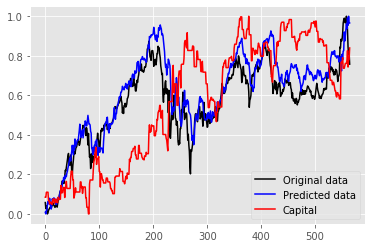

In [ ]:
#@title <b><font color="gree" size="+2">Quick analysis (prediction and backtesting) {display-mode: "form"}

#@markdown The amount of initial capital.
CAPITAL = 100000 #@param {type:"integer"}
#@markdown The share of capital to which we open the order.
CHAST = 0.05 #@param {type:"slider", min:0.05, max:1, step:0.05}
#@markdown The size of the commission for opening/closing an order (%).
KOMISSIYA = 0.05 #@param {type:"slider", min:0, max:1, step:0.05}
KOMISSIYA = KOMISSIYA / 100

#@markdown Choose a pre-trained model for your stock
MODEL = 'AMZN' #@param ["GAZP", "SBER", "ROSN", "VTBR", "TSLA", "GOOG", "AMZN", "FB"]
#@markdown If you did not find the pre-trained model you need in the drop-down list, then you can train it yourself.
new_training = False #@param {type:"boolean"}
#@markdown If the quality of the trained model is low, it is therefore proposed to skip this block and proceed to the next.

if new_training == True:
  model = Sequential()
  model.add(Conv1D(input_shape = (WINDOW, EMB_SIZE),filters=16,kernel_size=4,padding='same'))
  model.add(MaxPooling1D(pool_size=3))
  model.add(LeakyReLU())
  model.add(Conv1D(filters=32,kernel_size=4,padding='same'))
  model.add(MaxPooling1D(pool_size=3))
  model.add(LeakyReLU())
  model.add(LSTM(32,return_sequences=True))
  model.add(Flatten())
  model.add(Dense(16))
  model.add(LeakyReLU())
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('linear'))
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
  checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
  model.compile(optimizer=Adam(lr=0.002), loss='mean_absolute_error')
  history = model.fit(X_train, Y_train, 
                epochs = 100, 
                batch_size = 256, 
                verbose=1, 
                validation_data=(X_test, Y_test),
                callbacks=[reduce_lr, checkpointer],
                shuffle=True)
else:
  if MODEL == 'GAZP':
    !gdown https://drive.google.com/uc?id=1LEFpCsKPK_LLvZDcs4exZ0hhQbUYgo7r
  elif MODEL == 'SBER':
    !gdown https://drive.google.com/uc?id=1V1LhIVUGLXUZ66ajbEpqwZvBiuCTQjba
  elif MODEL == 'ROSN':
    !gdown https://drive.google.com/uc?id=1XM6CcZVBstRTt9PEGnqaLmGw_87QNKOE
  elif MODEL == 'VTBR':
    !gdown https://drive.google.com/uc?id=19k4dOmq4gyQPbSwCMcX6d0lHSN3jXSYH
  elif MODEL == 'TSLA':
    !gdown https://drive.google.com/uc?id=1r5uYwTEiljCg4EBICk3kOFz2xI3FRQWK
  elif MODEL == 'GOOG':
    !gdown https://drive.google.com/uc?id=1NrfxLgei-lPCvNxJ6FRRPTlgj8W1l5W3
  elif MODEL == 'AMZN':
    !gdown https://drive.google.com/uc?id=1BO8Nv2LBnyf8RDwSkzDcV-dWIpd21D3i
  elif MODEL == 'FB':
    !gdown https://drive.google.com/uc?id=1ewHlSXJEZZkFFVaa6hxGIdVBV6D2ZXno
  !unzip -u model.zip
  model = load_model("model.h5")
  model.load_weights("weights.h5")
  !rm model.zip
  !rm weights.h5
  !rm model.h5

pred = model.predict(X_test)
predicted = pred
original = Y_test

data_original.reset_index(inplace=True) # Вытаскиваем Дату из индекса
test_dates = pd.DataFrame(np.array(data_original["Date"][-len(Y_test):]))
test_price = pd.DataFrame(np.array(data_original["Close"][-len(Y_test):]))
data_original = data_original.set_index('Date') # устанавливаем Дату как индекс обратно
test_signal = pd.DataFrame(np.array(find_result(pd.DataFrame(pred))))
backtest = pd.concat([test_dates, test_price, test_signal], axis=1)
backtest.columns = (['Date', 'Price', 'Signal'])

balans = []
balans.append(CAPITAL)
capital_now = CAPITAL
signal_now = backtest['Signal'][0]
price_now = backtest['Price'][0]
change_now = 0.0

for i in range(1,len(backtest)): # перебираем все сигналы
  if signal_now == backtest['Signal'][i]: # если текущий сигнал совпадает с изначальным, тогда
    balans.append(capital_now) # ничего не меняем и переписываем текущий капитал
  else: # если же сигнал поменялся, то
    change_now = (backtest['Price'][i] - price_now) / price_now # считаем изменение цены
    if signal_now > 0.5: # если изначально был сигнал на рост
      #-------------------------------
      total = capital_now * CHAST # считаем сумму для открытия ордера
      capital_now = capital_now - total # при открытии отнимаем эту сумму от капитала
      komis_open = total * KOMISSIYA # считаем комиссию за открытие сделки
      total = total + (total * change_now) # расчитываем сумму с учетом изменения цены актива
      komis_close = total * KOMISSIYA # считаем комиссию за закрытие сделки
      total = total - komis_open - komis_close # считаем сумму за вычетом комиссий
      capital_now = capital_now + total # при закрытии ордера прибавляем сумму от капитала
      balans.append(capital_now) # и переписываем текущий капитал
      #-------------------------------
      signal_now = backtest['Signal'][i] # обновляем нынешний сигнал
      price_now = backtest['Price'][i] # обновляем нынешнюю цену      
    else: # если сигнал был на падение
      #-------------------------------
      total = capital_now * CHAST # считаем сумму для открытия ордера
      capital_now = capital_now - total # при открытии отнимаем эту сумму от капитала
      komis_open = total * KOMISSIYA # считаем комиссию за открытие сделки
      total = total - (total * change_now) # расчитываем сумму с учетом изменения цены актива
      komis_close = total * KOMISSIYA # считаем комиссию за закрытие сделки
      total = total - komis_open - komis_close # считаем сумму за вычетом комиссий
      capital_now = capital_now + total # при закрытии ордера прибавляем сумму от капитала
      balans.append(capital_now) # и переписываем текущий капитал
      #-------------------------------
      signal_now = backtest['Signal'][i] # обновляем нынешний сигнал
      price_now = backtest['Price'][i] # обновляем нынешнюю цену

backtest['Capital'] = pd.DataFrame(balans)
from IPython.display import clear_output
clear_output()

orig = pd.DataFrame(original)
perd = pd.DataFrame(predicted)
capi = pd.DataFrame(np.array(backtest['Capital']))
itog = pd.concat([orig, perd, capi], axis=1)
itog.columns = (['orig', 'perd', 'capi'])
itog['orig'] = min_max_scaler.fit_transform(itog.orig.values.reshape(-1,1))
itog['perd'] = min_max_scaler.fit_transform(itog.perd.values.reshape(-1,1))
itog['capi'] = min_max_scaler.fit_transform(itog.capi.values.reshape(-1,1))
print("Portfolio Change:", round((itog['capi'][len(itog['capi'])-1] - itog['capi'][0])*100, 1),"% in", len(itog['capi']), "days")
plt.plot(itog['orig'], color = 'black', label = 'Original data')
plt.plot(itog['perd'], color = 'blue', label = 'Predicted data')
plt.plot(itog['capi'], color = 'red', label = 'Capital')
plt.legend()
plt.show()

## <b><font color="gree" size="+2">Main analysis with fine tuning (training, prediction and backtesting)

Below in the sections "***Build the network architecture***" and "***Train the neural network***" it will be proposed to manually configure the entire process of training the neural network. In addition, it will also be possible to download the architecture and network weights, which can be taken [**HERE**](https://drive.google.com/open?id=1ln7tEV5YQf-imL7DzoyLIU2BfoP1PqIF).

### <b><font color="black" size="+1">Build the network architecture

If you want to use the created architecture, you can upload the **model.h5**

In [ ]:
# --- Upload the file to the server ---
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
# --------------------------------

model = load_model("model.h5")
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

If not, then build it yourself

In [ ]:
'''# --- New version ---
model= Sequential()
model.add(Conv1D(input_shape = (WINDOW, EMB_SIZE),filters=16,kernel_size=4,padding='same'))
model.add(MaxPooling1D(pool_size=3))
model.add(LeakyReLU())
model.add(Conv1D(filters=32,kernel_size=4,padding='same'))
model.add(MaxPooling1D(pool_size=3))
model.add(LeakyReLU())
model.add(LSTM(64,return_sequences=True))
model.add(Flatten())
model.add(Dense(32))
model.add(LeakyReLU())
model.add(Dropout(0.7))
model.add(Dense(1))
model.add(Activation('linear'))
# --------------------'''

# --- Old version (stable) ---
model = Sequential()
model.add(Conv1D(input_shape = (WINDOW, EMB_SIZE),filters=16,kernel_size=4,padding='same'))
model.add(MaxPooling1D(2))
model.add(LeakyReLU())
model.add(Conv1D(filters=64,kernel_size=4,padding='same'))
model.add(MaxPooling1D(2))
model.add(LeakyReLU())
model.add(Flatten())
model.add(Dense(32))
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('linear'))
# ---------------------

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error') # mean_absolute_error, mean_squared_error

model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

### <b><font color="black" size="+1">Train the neural network

If you want to use an already trained network, you can upload the file file with **weights.h5**

In [ ]:
# --- Upload the file to the server ---
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
# --------------------------------

model.load_weights("weights.h5")
pred = model.predict(X_test)
predicted = pred
original = Y_test

If not, then train yourself

In [ ]:
start = time()
history = model.fit(X_train, Y_train, 
              epochs = 100, 
              batch_size = 256, 
              verbose=1, 
              validation_data=(X_test, Y_test),
              callbacks=[reduce_lr, checkpointer],
              shuffle=True)
finish = time()

Save prediction results

In [ ]:
print("Seconds passed:", finish - start)
pred = model.predict(X_test)
predicted = pred
original = Y_test

Result visualization

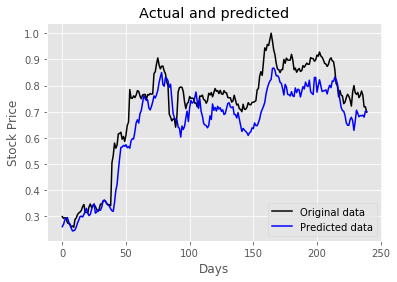

In [ ]:
plt.title('Actual and predicted')
plt.plot(original, color = 'black', label = 'Original data')
plt.plot(predicted, color = 'blue', label = 'Predicted data')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### <b><font color="black" size="+1">Evaluate the accuracy of the model



In [ ]:
predic = pd.DataFrame(predicted)
fact = pd.DataFrame(original)
itog = pd.concat([predic, fact], axis=1)
itog.columns = (['pred', 'fact'])
itog["predUD"] = find_result(predic)
itog["factUD"] = find_result(fact)

true_long = 0
true_short = 0
vern = 0

for i in range(0,len(itog)):
  if itog["predUD"][i] > 0.5 and itog["factUD"][i] > 0.5:
    true_long = true_long + 1
  elif itog["predUD"][i] < 0.5 and itog["factUD"][i] < 0.5:
    true_short = true_short + 1
  
  if itog["predUD"][i] == itog["factUD"][i]:
    vern = vern + 1
    
per_long = round((true_long/len(itog[itog["factUD"]>0.5]))*100,2)
per_short = round((true_short/len(itog[itog["factUD"]<0.5]))*100,2)
per_vern = round((vern/len(itog))*100,2)

print("Percentage of open orders for increase:", per_long)
print("Percentage of open orders for decrease:", per_short)
print("")
print("The percentage of correct forecasts:", per_vern)
print("--------------------------------------")
itog.head()

In [ ]:
print ("MSE =", np.mean(np.square(predicted - original)))
print ("MAE =", np.mean(np.abs(predicted - original)))
print ("MAPE =", np.mean(np.abs((original - predicted) / original)))

MSE = 0.07131233666676697
MAE = 0.2025770944113796
MAPE = 0.35941051355341186


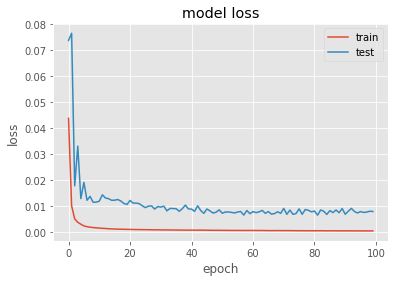

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### <b><font color="black" size="+1">Backtesting

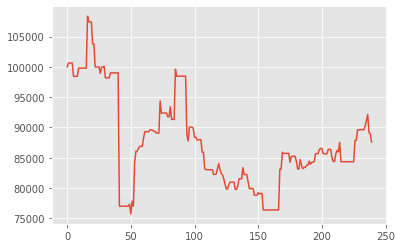

In [ ]:
data_original.reset_index(inplace=True)
test_dates = pd.DataFrame(np.array(data_original["Date"][-len(Y_test):]))
test_price = pd.DataFrame(np.array(data_original["Close"][-len(Y_test):]))
data_original = data_original.set_index('Date')
test_signal = pd.DataFrame(np.array(find_result(pd.DataFrame(pred))))
backtest = pd.concat([test_dates, test_price, test_signal], axis=1)
backtest.columns = (['Date', 'Price', 'Signal'])

CAPITAL = 100000.0 # amount of initial capital
CHAST = 1 # 0.05 = 5% share of the capital for which we open the order
KOMISSIYA = 0.0005 # 0.0005 = 0.05% commission for opening/closing an order

balans = []
balans.append(CAPITAL)
capital_now = CAPITAL
signal_now = backtest['Signal'][0]
price_now = backtest['Price'][0]
change_now = 0.0

for i in range(1,len(backtest)):
  if signal_now == backtest['Signal'][i]: # if the current signal matches the original, then
    balans.append(capital_now) # do not change anything and rewrite current capital
  else: # if the signal has changed, then
    change_now = (backtest['Price'][i] - price_now) / price_now # calculate the price change
    if signal_now > 0.5: # if a signal to increase stock prices
      #-------------------------------
      total = capital_now * CHAST # calculate the amount to open an order
      capital_now = capital_now - total # at the opening we subtract this amount from the capital
      komis_open = total * KOMISSIYA # we calculate the commission for opening an order
      total = total + (total * change_now) # calculate the amount taking into account changes in the price of an asset
      komis_close = total * KOMISSIYA # we calculate the commission for closing an order
      total = total - komis_open - komis_close # calculate the amount minus commissions
      capital_now = capital_now + total # when closing an order, add the amount of capital
      balans.append(capital_now) # and rewrite current capital
      #-------------------------------
      signal_now = backtest['Signal'][i] # update current signal
      price_now = backtest['Price'][i] # update current price   
    else: # if a signal to decrease stock prices
      #-------------------------------
      total = capital_now * CHAST # calculate the amount to open an order
      capital_now = capital_now - total # at the opening we subtract this amount from the capital
      komis_open = total * KOMISSIYA # we calculate the commission for opening an order
      total = total - (total * change_now) # calculate the amount taking into account changes in the price of an asset
      komis_close = total * KOMISSIYA # we calculate the commission for closing an order
      total = total - komis_open - komis_close # calculate the amount minus commissions
      capital_now = capital_now + total # when closing an order, add the amount of capital
      balans.append(capital_now) # and rewrite current capital
      #-------------------------------
      signal_now = backtest['Signal'][i] # update current signal
      price_now = backtest['Price'][i] # update current price

backtest['Capital'] = pd.DataFrame(balans)
plt.plot(backtest['Capital'])
plt.show()

### <b><font color="black" size="+1">Save the model

In [ ]:
# Save the weight and architecture of the neural network
model.save_weights('weights.h5', overwrite=True)
model.save('model.h5', overwrite=True)

# Save the network architecture in JSON format
model_json = model.to_json()
json_file = open("test.json", "w")
json_file.write(model_json)
json_file.close()

In [ ]:
# Download file to local
from google.colab import files
files.download("weights.h5")
files.download("model.h5")
files.download("test.json")